In [1]:
import pandas as pd

In [2]:
import numpy as np
import unidecode
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import RSLPStemmer

import nltk
import matplotlib.pyplot as plt
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to /home/marcelo/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')

In [4]:
df_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [5]:
df_reviews["review_comment_title"].notnull().sum()

11568

In [6]:
df_reviews["review_comment_message"].notnull().sum()

40977

### limpando dataset

removendo linhas com valores nulos da coluna 'review_comment_title' e 'review_score'

In [7]:
# drop na values from review_comment_message and review_score
df_reviews = df_reviews.dropna(subset=['review_comment_message', 'review_score'])

### Estrelas baixas
Checando se o titulo para estrelas baixas demonstra insatisfação

In [8]:
df_reviews.loc[df_reviews["review_score"] == 1]["review_comment_title"].value_counts()

Não recomendo              43
Ruim                       35
não recomendo              34
Produto errado             29
Não recebi o produto       26
                           ..
Não recebi ainda            1
Comprei dois filtros...     1
Irritante                   1
nao funciona telefones      1
Empres não confiável        1
Name: review_comment_title, Length: 1175, dtype: int64

### Premissas:
- Estrelas baixas são estrelas com 3 estrelas ou menos
- Um comentário com 3 estrelas ou menos é considerado insatisfeito obrigatoriamente
- Um comentário com 4 estrelas ou mais é considerado satisfatório obrigatoriamente

In [9]:
# Função para pré-processar o texto
def preprocess_text(text):

    # check if text is nan (from pandas)
    if not isinstance(text, str):
        return ''

    # Convertendo para minúsculas e removendo acentos
    text = unidecode.unidecode(text)
    text = text.lower()
    
    # Removendo pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Removendo números
    text = re.sub(r'\d+', '', text)
    
    # Tokenizando o texto
    tokens = word_tokenize(text)
    
    # Removendo stop words
    stop_words = set(stopwords.words('portuguese'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Aplicando stemmer em cada token
    stemmer = RSLPStemmer()
    tokens = [stemmer.stem(token) for token in tokens]


    # Juntando os tokens novamente em uma string
    text = ' '.join(tokens)
    
    return text

In [10]:
df_reviews["review_comment_message_preprocessed"] = df_reviews["review_comment_message"].apply(preprocess_text)
df_reviews["review_comment_title_preprocessed"] = df_reviews["review_comment_title"].apply(preprocess_text)

/tmp/ipykernel_5271/3540603209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews["review_comment_message_preprocessed"] = df_reviews["review_comment_message"].apply(preprocess_text)
/tmp/ipykernel_5271/3540603209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews["review_comment_title_preprocessed"] = df_reviews["review_comment_title"].apply(preprocess_text)


In [76]:
df_reviews["review_comment_message_preprocessed"]

3                               receb bem ant praz estipul
4        parab loj lannist ador compr internet segur pr...
9        aparelh efici sit marc aparelh impress desinfe...
12                             pouc travandopel val ta boa
15                   vend confia produt ok entreg ant praz
                               ...                        
99205                      produt receb acord compr realiz
99208    entreg dentr praz produt cheg condico perfeit ...
99215    produt nao envi nf nao exist vend nf cert fic ...
99221            excel mochil entreg sup rap sup recom loj
99223      produt cheg ja devolv poi defeit nao segur carg
Name: review_comment_message_preprocessed, Length: 40977, dtype: object

In [77]:
# separando o dataframe em comentários positivos e comentários negativos

df_reviews_positivos = df_reviews[df_reviews["review_score"] >3]
df_reviews_negativos = df_reviews[df_reviews["review_score"] <= 3]

In [78]:
stopwords_portuguese = stopwords.words('portuguese')


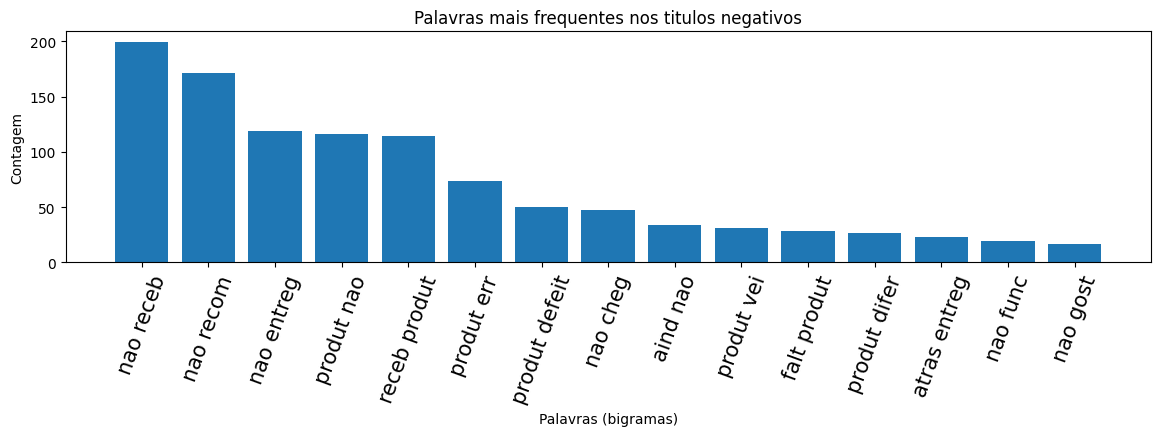

In [94]:
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True, ngram_range=(2,2))
x = vectorizer.fit_transform(df_reviews_negativos["review_comment_title_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_titulos_negativos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.ylabel("Contagem")
plt.xlabel("Palavras (bigramas)")
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos[0:n_palavras], rotation=70, fontsize=15)
plt.title("Palavras mais frequentes nos titulos negativos")
plt.show()

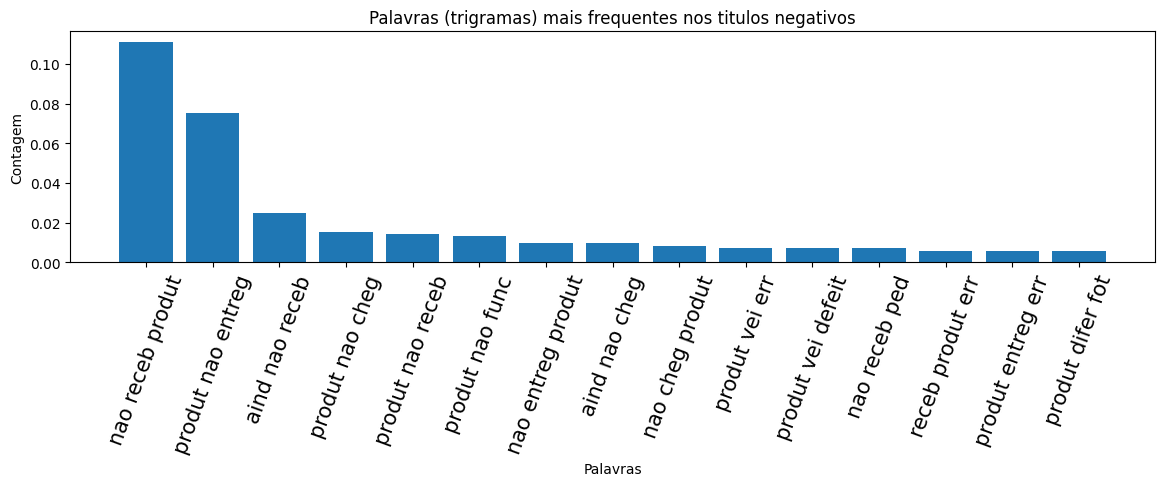

In [97]:
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True, ngram_range=(3,3))
x = vectorizer.fit_transform(df_reviews_negativos["review_comment_title_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_titulos_negativos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
frequencias = [t[0]/sum([t[0] for t in tuplas_ordenadas]) for t in tuplas_ordenadas] 
n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.ylabel("Contagem")
plt.xlabel("Palavras")
plt.bar(eixo_x[0:n_palavras], frequencias[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos[0:n_palavras], rotation=70, fontsize=15)
plt.title("Palavras (trigramas) mais frequentes nos titulos negativos")
plt.show()

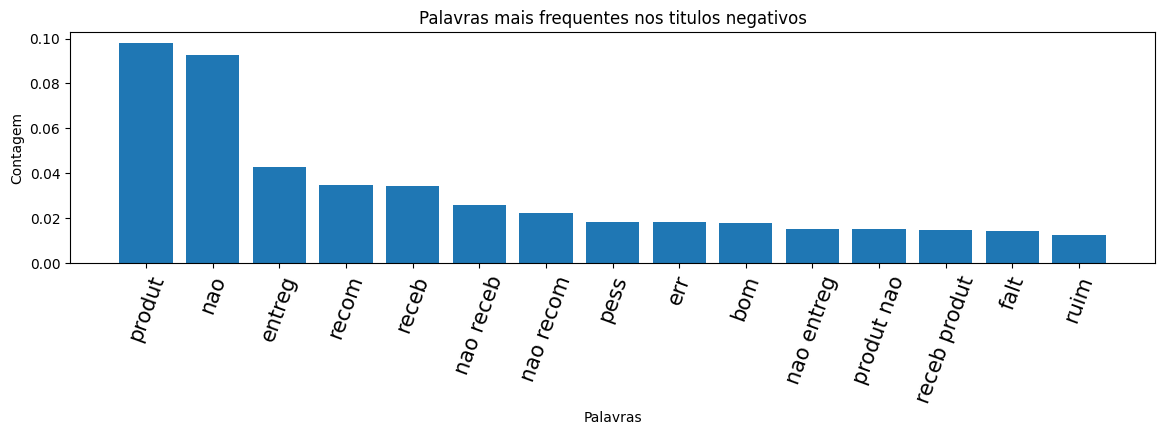

In [96]:
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True, ngram_range=(1,2))
x = vectorizer.fit_transform(df_reviews_negativos["review_comment_title_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_titulos_negativos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
frequencias = [t[0]/sum([t[0] for t in tuplas_ordenadas]) for t in tuplas_ordenadas]
n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.ylabel("Contagem")
plt.xlabel("Palavras")
plt.bar(eixo_x[0:n_palavras], frequencias[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos[0:n_palavras], rotation=70, fontsize=15)
plt.title("Palavras mais frequentes nos titulos negativos")
plt.show()

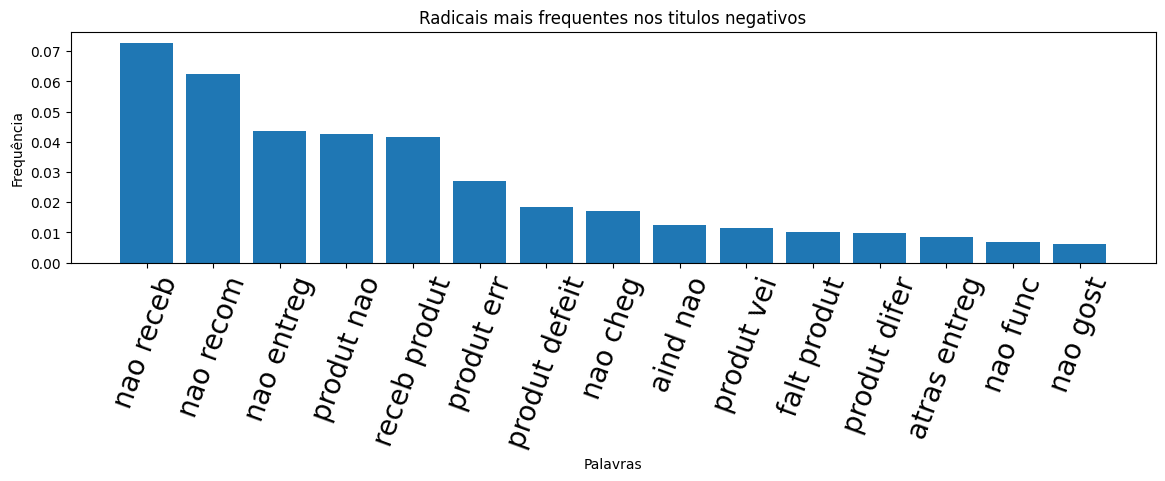

In [82]:
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=False,ngram_range=(2,2))
x = vectorizer.fit_transform(df_reviews_negativos["review_comment_title_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True)
palavras_titulos_negativos = [ t[1] for t in tuplas_ordenadas ]
frequencias = [t[0]/sum([t[0] for t in tuplas_ordenadas]) for t in tuplas_ordenadas]

n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.ylabel("Frequência")
plt.xlabel("Palavras")
plt.bar(eixo_x[0:n_palavras], frequencias[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos[0:n_palavras], rotation=70, fontsize=20)
plt.title("Radicais mais frequentes nos titulos negativos")
plt.show()


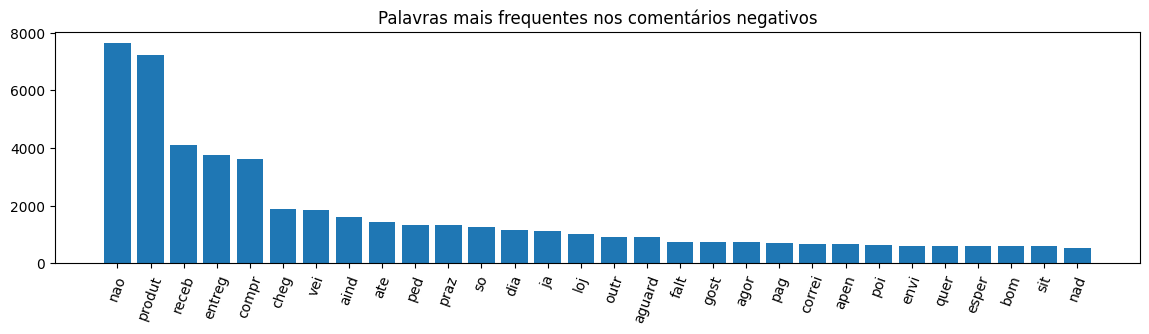

In [84]:
# mesma coisa para os os comentários negativos
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True)
x = vectorizer.fit_transform(df_reviews_negativos["review_comment_message_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_comentarios_negativos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_comentarios_negativos[0:n_palavras], rotation=70)
plt.title("Palavras mais frequentes nos comentários negativos")
plt.show()

### Análise empirica:
- Analisando os comentários e titulos de estrelas baixas, podemos ver que os titulos de estrelas baixas resumem o comentário, utilizando palavras como 'ruim', 'péssimo', 'não', 'falta', 'incompleto'.
- Enquanto que as mensagens de estrelas baixas são mais detalhadas, com palavras negativas mas também com palavras que não acrescentam tom negativo, como 'dia', 'loja', 'outro'.

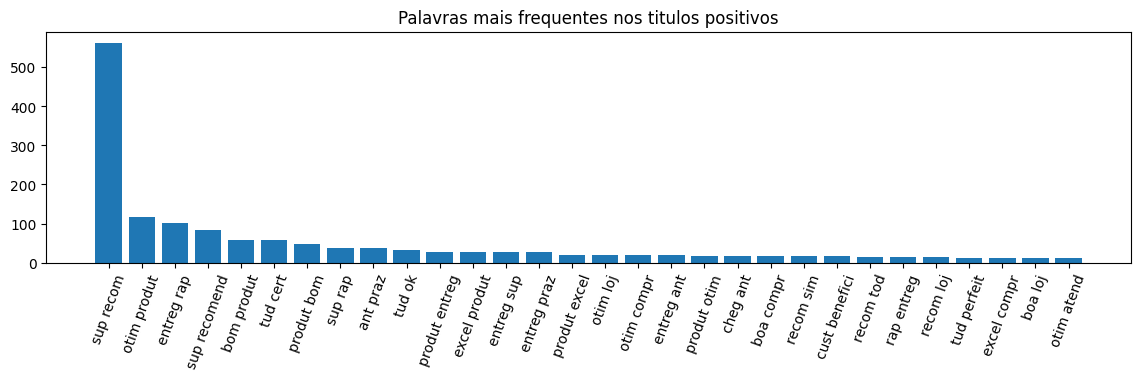

In [85]:
# mesma coisa para os os comentários positivos
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True, ngram_range=(2,2))
x = vectorizer.fit_transform(df_reviews_positivos["review_comment_title_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_titulos_positivos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.title("Palavras mais frequentes nos titulos positivos")
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_positivos[0:n_palavras], rotation=70)
plt.show()

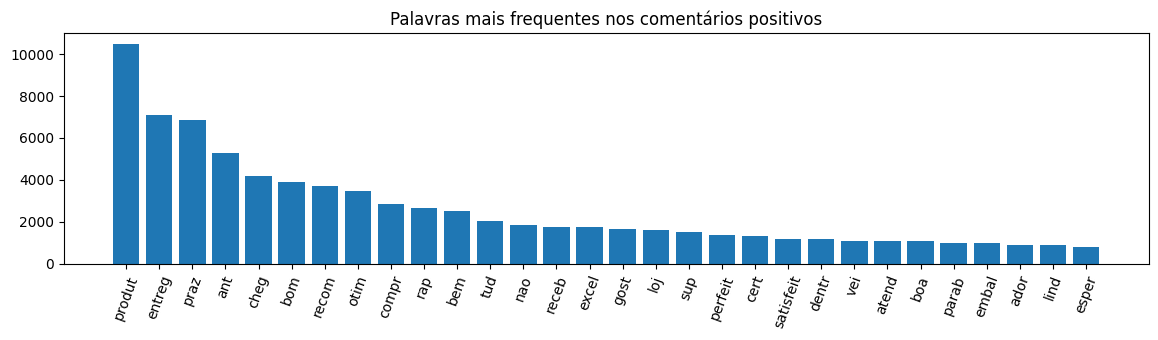

In [86]:
# mesma coisa para os os comentários positivos
vectorizer = CountVectorizer(stop_words=stopwords_portuguese, max_features=1000, binary=True)
x = vectorizer.fit_transform(df_reviews_positivos["review_comment_message_preprocessed"])
x = np.sum(x, axis=0)
tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras_comentarios_positivos = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_comentarios_positivos[0:n_palavras], rotation=70)
plt.title("Palavras mais frequentes nos comentários positivos")
plt.show()

### Análise empírica:
- Analisando os comentários e titulos de estrelas altas, podemos ver que os titulos de estrelas altas resumem o comentário, utilizando palavras como 'recomendo', 'ótimo', 'excelente', 'perfeito'.
- Enquanto que as mensagens de estrelas altas são mais detalhadas, com palavras positivas mas também com palavras que não acrescentam tom positivo, como 'prazo', 'chegou', 'loja'

### Continuação:
- A principio, podemos concluir que o gráfico de Palavras mais frequentes em titulos de estrelas baixas é um bom indicador de insatisfação, e o gráfico de Palavras mais frequentes em titulos de estrelas altas é um bom indicador de satisfação.

- Entretanto, é possível remover palavras que aparecem nos titulos positivos da lista de palavras mais frequentes em titulos de estrelas baixas, a fim de melhorar a análise.

- Dessa forma, vamos considerar só remover da lista de palavras negativas as 60 palavras mais frequentes em titulos de estrelas altas.  

In [92]:
# remover palavras que aparecem em ambos os datasets
# remova da lista palavras_titulos_negativos as palavras que aparecem em palavras_titulos_positivos

palavras_titulos_negativos_limpo = []
frequencias_limpo = []
for i in range(len(palavras_titulos_negativos)):
    # checar se a palavra está em palavras_titulos_positivos
    if palavras_titulos_negativos[i] in palavras_titulos_positivos:
        # se estiver, não adicionar a palavra a lista palavras_titulos_negativos_limpo
        # e não adicionar a frequencia a lista frequencias_limpo
        pass
    else:
        # se não estiver, adicionar a palavra a lista palavras_titulos_negativos_limpo
        # e adicionar a frequencia a lista frequencias_limpo
        palavras_titulos_negativos_limpo.append(palavras_titulos_negativos[i])
        frequencias_limpo.append(frequencias[i])

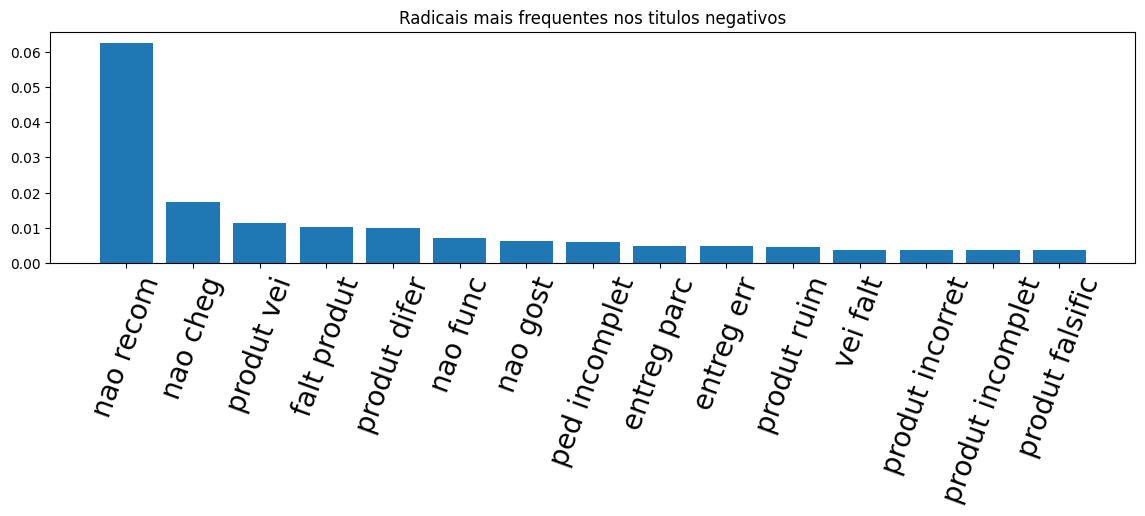

In [93]:

n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], frequencias_limpo[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos_limpo[0:n_palavras], rotation=70, fontsize=20)
plt.title("Radicais mais frequentes nos titulos negativos")
plt.show()


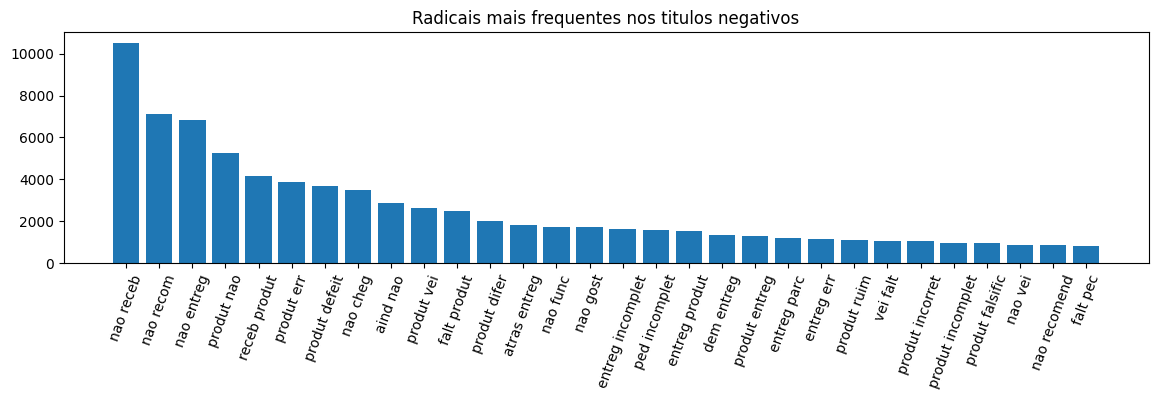

In [89]:
# faça o gráfico de barras com as palavras mais frequentes nos titulos negativos

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras_titulos_negativos[0:n_palavras], rotation=70)
plt.title("Radicais mais frequentes nos titulos negativos")
plt.show()
